<div align='left' style="width:400px;height:120px;overflow:hidden;">
<a href='http://www.uff.br'>
<img align='left' style='display: block;height: 92%' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/uff.png' alt='UFF logo' title='UFF logo'/>
</a>
<a href='http://www.ic.uff.br'>
<img align='left' style='display: block;height: 100%' src='https://github.com/lmarti/jupyter_custom/raw/master/imgs/logo-ic.png' alt='IC logo' title='IC logo'/>
</a>
</div>

# Evolutionary Multi-Objective Optimization

## Luis Martí, [IC](http://www.ic.uff.br)/[UFF](http://www.uff.br)

[http://lmarti.com](http://lmarti.com); [lmarti@ic.uff.br](mailto:lmarti@ic.uff.br) 

[Advanced Evolutionary Computation: Theory and Practice](http://lmarti.com/aec-2014) 

This notebook is better viewed rendered as slides. You can convert it to slides and view them by:
- using [nbconvert](http://ipython.org/ipython-doc/1/interactive/nbconvert.html) with a command like:
  ```bash
  $ ipython nbconvert --to slides --post serve <this-notebook-name.ipynb>
  ```
- installing [Reveal.js - Jupyter/IPython Slideshow Extension](https://github.com/damianavila/live_reveal)
- using the online [IPython notebook slide viewer](https://slideviewer.herokuapp.com/) (some slides of the notebook might not be properly rendered).

This and other related IPython notebooks can be found at the course github repository:
* [https://github.com/lmarti/evolutionary-computation-course](https://github.com/lmarti/evolutionary-computation-course)

# In this notebook

* Present the basic concepts related to evolutionary multi-objective optimization algorithms.
* The Non-dominated Sorting Genetic Algorithm II (NSGA-II).
* Benchmark test problems.
* Experiment design and results comparison.

## How can we handle multiple conflicting objectives?

Even choosing a fruit implies dealing with conflicting objectives.

<div align='center'><img src='http://imgs.xkcd.com/comics/fuck_grapefruit.png' width='56%' align='center'/>
taken from http://xkcd.com/388/</div>

# [Multi-objective optimization](http://en.wikipedia.org/wiki/Multi-objective_optimization)

* Most -*if not all*- optimization problems involve more than one objective function to be optimized simultaneously.
* For example, you must optimize a given feature of an object while keeping under control the resources needed to elaborate that object.
* Sometimes those other objectives are converted to constraints or fixed to default values, but that does not means that they are there.
* Multi-objective optimization is also known as *multi-objective programming*, *vector optimization*, *multicriteria optimization*, *multiattribute optimization* or *Pareto optimization* (and probably by other names, depending on the field).
* Multi-objective optimization has been applied in [many fields of science](http://en.wikipedia.org/wiki/Multi-objective_optimization#Examples_of_multi-objective_optimization_applications), including engineering, economics and logistics (see the section on applications for detailed examples) where optimal decisions need to be taken in the presence of trade-offs between two or more conflicting objectives.

## A Multi-objective Optimization Problem (MOP)

$$
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\set}[1]{\mathcal{#1}}
\newcommand{\dom}{\preccurlyeq}
\left.
\begin{array}{rl}
\mathrm{minimize}             & \vec{F}(\vec{x})=\langle f_1(\vec{x}),\ldots,f_M(\vec{x})\rangle\,,\\ 
\mathrm{subject}\ \mathrm{to} & c_1(\vec{x}),\ldots,c_C(\vec{x})\le 0\,,\\
							  & d_1(\vec{x}),\ldots,d_D(\vec{x})= 0\,,\\
& \text{with}\ \vec{x}\in\set{D}\,,
\end{array}\right\}
$$

* $\mathcal{D}$ is known as the *decision set* or *search set*.
* functions $f_1(\mathbf{x}),\ldots,f_M(\mathbf{x})$ are the *objective functions*. If $M=1$ the problem reduces to a single-objective optimization problem. 
* Image set, $\set{O}$, result of the projection of $\set{D}$ via $f_1(\vec{x}),\ldots,f_M(\vec{x})$ is called *objective set* ($\vec{F}:\set{D}\rightarrow\set{O}$).
* $c_1(\vec{x}),\ldots,c_C(\vec{x})\le 0$ and $d_1(\vec{x}),\ldots,d_D(\vec{x})= 0$  express the constraints imposed on the values of $\vec{x}$.

*Note:* In case you are -still- wondering, a maximization problem can be posed as the minimization one: $\min\ -\vec{F}(\vec{x})$.

## Example: A two variables and two objectives MOP
<img src='static/mop-2d.jpg' height='56%' align='center'/>

## MOP (optimal) solutions

Usually, there is not a unique solution that minimizes all objective functions simultaneously, but, instead, a set of equally good *trade-off* solutions.

* *Optimality* can be defined in terms of the [*Pareto dominance*](https://en.wikipedia.org/wiki/Pareto_efficiency) relation. That is, having $\vec{x},\vec{y}\in\set{D}$, $\vec{x}$ is said to dominate $\vec{y}$ (expressed as $\vec{x}\dom\vec{y}$) iff $\forall f_j$, $f_j(\vec{x})\leq f_j(\vec{y})$ and $\exists f_i$ such that $f_i(\vec{x})< f_i(\vec{y})$.
* Having the set $\set{A}$. $\set{A}^\ast$, the *non-dominated subset* of $\set{A}$, is defined as

$$
\set{A}^\ast=\left\{ \vec{x}\in\set{A} \left|\not\exists\vec{y}\in\set{A}:\vec{y}\dom\vec{x}\right.\right\}.
$$

* The *Pareto-optimal set*, $\set{D}^{\ast}$, is the solution of the problem. It is the subset of non-dominated elements of $\set{D}$. It is also known as the *efficient set*.
* It consists of solutions that cannot be improved in any of the objectives without degrading at least one of the other objectives.
* Its image in objective set is called the *Pareto-optimal front*, $\set{O}^\ast$.
* Evolutionary algorithms generally yield a set of non-dominated solutions, $\set{P}^\ast$, that approximates $\set{D}^{\ast}$.


As usual, we need some initialization and configuration.

In [6]:
import time, array, random, copy, math
import numpy as np
import pandas as pd

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

In [9]:
from deap import algorithms, base, benchmarks, tools, creator

Planting a constant seed to always have the same results (and avoid surprises in class). -*you should not do this in a real-world case!*

In [10]:
random.seed(a=42)

# Visualizing the Pareto dominance relation

* To start, lets have a visual example of the Pareto dominance relationship in action.
* In this notebook we will deal with two-objective problems in order to simplify visualization. 
* Therefore, we can create:

In [11]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", array.array, typecode='d', 
               fitness=creator.FitnessMin)

## Let's use an illustrative MOP problem: Dent

$$
\begin{array}{rl}
\text{minimize} & f_1(\vec{x}),f_2(\vec{x}) \\
\text{such that} & f_1(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} \sqrt{1 + (x_1 - x_2)^2} + x_1 -x_2\right) + d,\\
 & f_2(\vec{x}) = \frac{1}{2}\left( \sqrt{1 + (x_1 + x_2)^2} \sqrt{1 + (x_1 - x_2)^2} - x_1 -x_2\right) + d,\\
\text{with}& d = \lambda e^{-\left(x_1-x_2\right)^2}\ (\text{generally }\lambda=0.85) \text{ and } \vec{x}\in \left[-1.5,1.5\right]^2.
\end{array}
$$

Implementing the Dent problem

In [12]:
def dent(individual, lbda = 0.85):
    """ 
    Implements the test problem Dent
    Num. variables = 2; bounds in [-1.5, 1.5]; num. objetives = 2.
    @author Cesar Revelo
    """
    d  = lbda * math.exp(-(individual[0] - individual[1]) ** 2)  
    f1 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) + \
                individual[0] - individual[1]) + d
    f2 = 0.5 * (math.sqrt(1 + (individual[0] + individual[1]) ** 2) + \
                math.sqrt(1 + (individual[0] - individual[1]) ** 2) - \
                individual[0] + individual[1]) + d
    return f1, f2

Preparing a DEAP `toolbox` with Dent.

In [13]:
toolbox = base.Toolbox()

In [14]:
BOUND_LOW, BOUND_UP = -1.5, 1.5
NDIM = 2
# toolbox.register("evaluate", lambda ind: benchmarks.dtlz2(ind, 2))
toolbox.register("evaluate", dent)

Defining attributes, individuals and population.

In [15]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Creating an example population distributed as a mesh.

In [16]:
num_samples = 50
limits = [np.arange(BOUND_LOW, BOUND_UP, (BOUND_UP - BOUND_LOW)/num_samples)] * NDIM
sample_x = np.meshgrid(*limits)

In [17]:
flat = []
for i in range(len(sample_x)):
    x_i = sample_x[i]
    flat.append(x_i.reshape(num_samples**NDIM))

In [18]:
example_pop = toolbox.population(n=num_samples**NDIM)

In [19]:
for i, ind in enumerate(example_pop):
    for j in range(len(flat)):
        ind[j] = flat[j][i]

In [20]:
fitnesses = toolbox.map(toolbox.evaluate, example_pop)
for ind, fit in zip(example_pop, fitnesses):
    ind.fitness.values = fit

We also need `a_given_individual`.

In [21]:
a_given_individual = toolbox.population(n=1)[0]
a_given_individual[0] = 0.5
a_given_individual[1] = 0.5

In [22]:
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

Implementing the Pareto dominance relation between two individulas.

In [23]:
def pareto_dominance(ind1,ind2):
    'Returns `True` if `ind1` dominates `ind2`.'
    extrictly_better = False
    for item1 in ind1.fitness.values:
        for item2 in ind2.fitness.values:
            if item1 > item2:
                return False
            if not extrictly_better and item1 < item2:
                extrictly_better = True
    return extrictly_better

*Note:* Bear in mind that DEAP comes with a Pareto dominance relation that probably is more efficient than this implementation.
```python
def pareto_dominance(x,y):
    return tools.emo.isDominated(x.fitness.values, y.fitness.values)
```

Lets compute the set of individuals that are `dominated` by `a_given_individual`, the ones that dominate it (its `dominators`) and the remaining ones.

In [24]:
dominated = [ind for ind in example_pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in example_pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in example_pop if not ind in dominated and not ind in dominators]

In [25]:
def plot_dent():
    'Plots the points in decision and objective spaces.'
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for ind in dominators: plt.plot(ind[0], ind[1], 'r.')
    for ind in dominated: plt.plot(ind[0], ind[1], 'g.')
    for ind in others: plt.plot(ind[0], ind[1], 'k.', ms=3)
    plt.plot(a_given_individual[0], a_given_individual[1], 'bo', ms=6);
    plt.xlabel('$x_1$');plt.ylabel('$x_2$');
    plt.title('Decision space');
    plt.subplot(1,2,2)
    for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
    for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
    for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
    plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    plt.xlim((0.5,3.6));plt.ylim((0.5,3.6));
    plt.title('Objective space');
    plt.tight_layout()

Having `a_given_individual` (blue dot) we can now plot those that are dominated by it (in green), those that dominate it (in red) and those that are uncomparable.

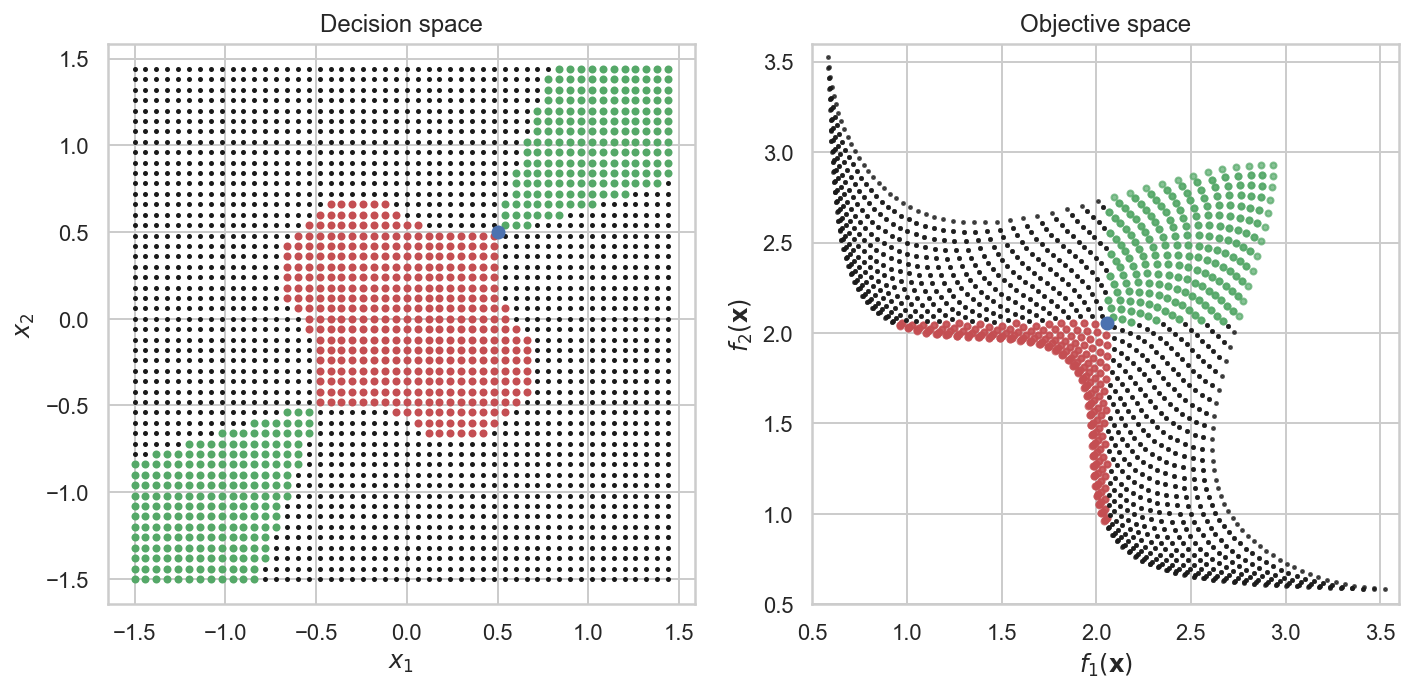

In [26]:
plot_dent()

Obtaining the nondominated front.

In [27]:
non_dom = tools.sortNondominated(example_pop, k=len(example_pop), first_front_only=True)[0]

Text(0.5, 1.0, 'Pareto-optimal front')

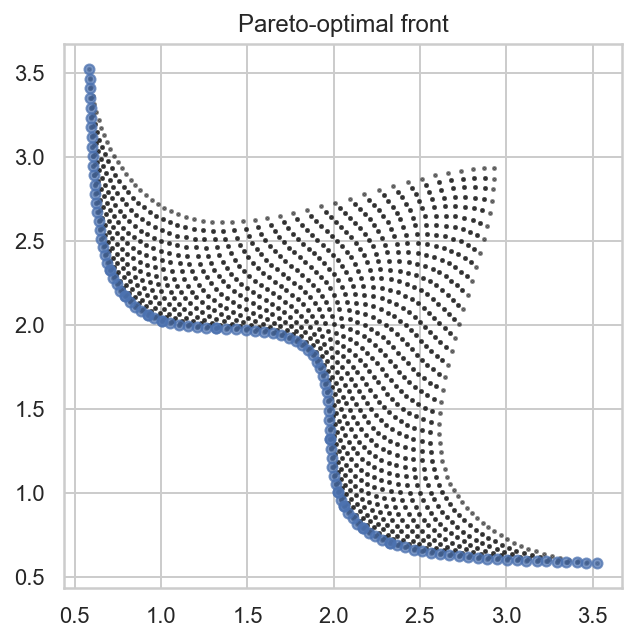

In [28]:
plt.figure(figsize=(5,5))
for ind in example_pop:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3, alpha=0.5)
for ind in non_dom:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo', alpha=0.74, ms=5)
plt.title('Pareto-optimal front')

# The Non-dominated Sorting Genetic Algorithm (NSGA-II)

* NSGA-II algorithm is one of the pillars of the EMO field.
    * Deb, K., Pratap, A., Agarwal, S., Meyarivan, T., *A fast and elitist multiobjective genetic algorithm: NSGA-II*, IEEE Transactions on Evolutionary Computation, vol.6, no.2, pp.182,197, Apr 2002 doi: [10.1109/4235.996017](http://dx.doi.org/10.1109/4235.996017).
* Fitness assignment relies on the Pareto dominance relation:
    1. Rank individuals according the dominance relations established between them. 
    2. Individuals with the same domination rank are then compared using a local crowding distance.

## NSGA-II fitness in detail

* The first step consists in classifying the individuals in a series of categories $\mathcal{F}_1,\ldots,\mathcal{F}_L$. 
* Each of these categories store individuals that are only dominated by the elements of the previous categories,
$$
\begin{array}{rl}
	\forall \vec{x}\in\set{F}_i: &\exists \vec{y}\in\set{F}_{i-1} \text{ such that } \vec{y}\dom\vec{x},\text{ and }\\ 
	                            &\not\exists\vec{z}\in \set{P}_t\setminus\left( \set{F}_1\cup\ldots\cup\set{F}_{i-1}
	                            \right)\text{ that }\vec{z}\dom\vec{x}\,;
\end{array}
$$
with $\mathcal{F}_1$ equal to $\mathcal{P}_t^\ast$, the set of non-dominated individuals of $\mathcal{P}_t$.

* After all individuals are ranked a local crowding distance is assigned to them. 
* The use of this distance primes individuals more isolated with respect to others. 

## Crowding distance

The assignment process goes as follows,

* for each category set $\set{F}_l$, having $f_l=|\set{F}_l|$,
    * for each individual $\vec{x}_i\in\set{F}_l$, set $d_{i}=0$.
    * for each objective function $m=1,\ldots,M$,
        * $\vec{I}=\mathrm{sort}\left(\set{F}_l,m\right)$ (generate index vector).
        * $d_{I_1}^{(l)}=d_{I_{f_l}}^{(l)}=\infty$.
        * for $i=2,\ldots,f_l-1$,
            * Update the remaining distances as,
                $$
                d_i = d_i + \frac{f_m\left(\vec{x}_{I_{i+1}}\right)-f_m\left(\vec{x}_{I_{i+1}}\right)}
			                   {f_m\left(\vec{x}_{I_{1}}\right)-f_m\left(\vec{x}_{I_{f_l}}\right)}\,.
                $$

Here the $\mathrm{sort}\left(\set{F},m\right)$ function produces an ordered index vector $\vec{I}$ with respect to objective function $m$. 

Sorting the population by rank and distance.

* Having the individual ranks and their local distances they are sorted using the crowded comparison operator, stated as: 
    * An individual $\vec{x}_i$ _is better than_ $\vec{x}_j$ if:
        * $\vec{x}_i$ has a better rank: $\vec{x}_i\in\set{F}_k$, $\vec{x}_j\in\set{F}_l$ and $k<l$, or;
        * if $k=l$ and $d_i>d_j$.
        
**Now we have key element of the the non-dominated sorting GA.**

## Implementing NSGA-II

We will deal with [DTLZ3](http://www.tik.ee.ethz.ch/sop/download/supplementary/testproblems/dtlz3/), which is a more difficult test problem.

* DTLZ problems can be configured to have as many objectives as desired, but as we want to visualize results we will stick to two objectives.
* DTLZ3 is a (more complex) version of [DTLZ2](http://www.tik.ee.ethz.ch/sop/download/supplementary/testproblems/dtlz2/).
* The Pareto-optimal front of DTLZ3 lies in the first [orthant](http://en.wikipedia.org/wiki/Orthant) of a unit (radius 1) hypersphere located at the coordinate origin ($\vec{0}$).
* It has many local optima that run parallel to the global optima and render the optimization process more complicated.

<div align='center'><img src='http://www.cs.cinvestav.mx/~emoobook/apendix-e/galeria4/dtlz3a.jpg' width="38%" align='center'/>
from Coello Coello, Lamont and Van Veldhuizen (2007) Evolutionary Algorithms for Solving Multi-Objective Problems, Second Edition. Springer [Appendix E](http://www.cs.cinvestav.mx/~emoobook/apendix-e/apendix-e.html).</div>

New `toolbox` instance with the necessary components.

In [ ]:
toolbox = base.Toolbox()

Define problem domain as $\vec{x}\in\left[0,1\right]^{30}$ and a two-objective DTLZ3 instance.

In [ ]:
NDIM = 30 
BOUND_LOW, BOUND_UP = 0.0, 1.0
toolbox.register("evaluate", lambda ind: benchmarks.dtlz3(ind, 2))

Describing attributes, individuals and population and defining the selection, mating and mutation operators.

In [ ]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

Let's also use the `toolbox` to store other configuration parameters of the algorithm. This will show itself usefull when performing massive experiments.

In [ ]:
toolbox.pop_size = 50
toolbox.max_gen = 1000
toolbox.mut_prob = 0.2

## A compact NSGA-II implementation

Storing all the required information in the `toolbox` and using DEAP's `algorithms.eaMuPlusLambda` function allows us to create a very compact -albeit not a 100% exact copy of the original- implementation of NSGA-II.

In [ ]:
def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)

## Running the algorithm

We are now ready to run our NSGA-II.

In [ ]:
%time res,_ = run_ea(toolbox)

We can now get the Pareto fronts in the results (`res`).

In [ ]:
fronts = tools.emo.sortLogNondominated(res, len(res))

## Resulting Pareto fronts

In [ ]:
plot_colors = seaborn.color_palette("Set1", n_colors=10)
fig, ax = plt.subplots(1, figsize=(4,4))
for i,inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)
    df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], 
                 color=plot_colors[i])
plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');

* It is better to make an animated plot of the evolution as it takes place.

## Animating the evolutionary process

We create a `stats` to store the individuals not only their objective function values.

In [ ]:
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

In [ ]:
toolbox.max_gen = 1000 # we need more generations!

Re-run the algorithm to get the data necessary for plotting.

In [ ]:
%time res, logbook = run_ea(toolbox, stats=stats)

In [ ]:
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def animate(frame_index, logbook):
    'Updates all plots to match frame _i_ of the animation.'
    ax.clear()    
    fronts = tools.emo.sortLogNondominated(logbook.select('pop')[frame_index], 
                                           len(logbook.select('pop')[frame_index]))
    for i,inds in enumerate(fronts):
        par = [toolbox.evaluate(ind) for ind in inds]
        df = pd.DataFrame(par)
        df.plot(ax=ax, kind='scatter', label='Front ' + str(i+1), 
                 x=df.columns[0], y=df.columns[1], alpha=0.47,
                 color=plot_colors[i % len(plot_colors)])
        
    ax.set_title('$t=$' + str(frame_index))
    ax.set_xlabel('$f_1(\mathbf{x})$');ax.set_ylabel('$f_2(\mathbf{x})$')
    return []

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.gca()
anim = animation.FuncAnimation(fig, lambda i: animate(i, logbook), 
                               frames=len(logbook), interval=60, 
                               blit=True)
plt.close()

In [ ]:
HTML(anim.to_html5_video())

Here it is clearly visible how the algorithm "jumps" from one local-optimum to a better one as evolution takes place.

# MOP benchmark problem toolkits

Each problem instance is meant to test the algorithms with regard with a given feature: local optima, convexity, discontinuity, bias, or a combination of them.

* [*ZDT1-6*](http://www.tik.ee.ethz.ch/sop/download/supplementary/testproblems/): Two-objective problems with a fixed number of decision variables.
     * E. Zitzler, K. Deb, and L. Thiele. Comparison of Multiobjective Evolutionary Algorithms: Empirical Results. Evolutionary Computation, 8(2):173-195, 2000. ([pdf](http://www.tik.ee.ethz.ch/sop/publicationListFiles/zdt2000a.pdf))
* [*DTLZ1-7*](http://www.tik.ee.ethz.ch/sop/download/supplementary/testproblems/): $m$-objective problems with $n$ variables.
     * K. Deb, L. Thiele, M. Laumanns and E. Zitzler. Scalable Multi-Objective Optimization Test Problems. CEC 2002, p. 825 - 830, IEEE Press, 2002. ([pdf](http://www.tik.ee.ethz.ch/sop/publicationListFiles/dtlz2002a.pdf))

* [*CEC'09*](http://dces.essex.ac.uk/staff/zhang/moeacompetition09.htm): Two- and three- objective problems that very complex Pareto sets.
    * Zhang, Q., Zhou, A., Zhao, S., & Suganthan, P. N. (2009). Multiobjective optimization test instances for the CEC 2009 special session and competition. In 2009 IEEE Congress on Evolutionary Computation (pp. 1–30). ([pdf](http://dces.essex.ac.uk/staff/zhang/MOEAcompetition/cec09testproblem0904.pdf.pdf))
* [*WFG1-9*](http://www.wfg.csse.uwa.edu.au/publications.html#toolkit): $m$-objective problems with $n$ variables, very complex.
    * Huband, S., Hingston, P., Barone, L., & While, L. (2006). A review of multiobjective test problems and a scalable test problem toolkit. IEEE Transactions on Evolutionary Computation, 10(5), 477–506. doi:10.1109/TEVC.2005.861417

How does our NSGA-II behaves when faced with different benchmark problems?

In [ ]:
problem_instances = {'ZDT1': benchmarks.zdt1, 'ZDT2': benchmarks.zdt2,
                     'ZDT3': benchmarks.zdt3, 'ZDT4': benchmarks.zdt4,
                     'DTLZ1': lambda ind: benchmarks.dtlz1(ind,2),
                     'DTLZ2': lambda ind: benchmarks.dtlz2(ind,2),
                     'DTLZ3': lambda ind: benchmarks.dtlz3(ind,2),
                     'DTLZ4': lambda ind: benchmarks.dtlz4(ind,2, 100),
                     'DTLZ5': lambda ind: benchmarks.dtlz5(ind,2),
                     'DTLZ6': lambda ind: benchmarks.dtlz6(ind,2),
                     'DTLZ7': lambda ind: benchmarks.dtlz7(ind,2)}

In [ ]:
toolbox.max_gen = 1000

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("obj_vals", np.copy)

def run_problem(toolbox, problem):
    toolbox.register('evaluate', problem)
    return run_ea(toolbox, stats=stats)

Running NSGA-II solving all problems. Now it takes longer.

In [ ]:
%time results = {problem: run_problem(toolbox, problem_instances[problem]) for problem in problem_instances}

Creating this animation takes more programming effort.

In [ ]:
class MultiProblemAnimation:
    def init(self, fig, results):
        self.results = results
        self.axs = [fig.add_subplot(3,4,i+1) for i in range(len(results))]
        self.plots =[]
        for i, problem in enumerate(sorted(results)):
            (res, logbook) = self.results[problem]
            pop = pd.DataFrame(data=logbook.select('obj_vals')[0])
            plot = self.axs[i].plot(pop[0], pop[1], 'b.', alpha=0.47)[0]
            self.plots.append(plot)
        fig.tight_layout()
            
    def animate(self, t):
        'Updates all plots to match frame _i_ of the animation.'
        for i, problem in enumerate(sorted(results)):
            #self.axs[i].clear()
            (res, logbook) = self.results[problem]
            pop = pd.DataFrame(data=logbook.select('obj_vals')[t])
            self.plots[i].set_data(pop[0], pop[1])
            self.axs[i].set_title(problem + '; $t=' + str(t)+'$') 
            self.axs[i].set_xlim((0, max(1,pop.max()[0])))
            self.axs[i].set_ylim((0, max(1,pop.max()[1])))
        return self.axs

In [ ]:
mpa = MultiProblemAnimation()

In [ ]:
fig = plt.figure(figsize=(14,6))
anim = animation.FuncAnimation(fig, mpa.animate, init_func=mpa.init(fig,results), 
                               frames=toolbox.max_gen, interval=60, blit=True)
plt.close()

In [ ]:
HTML(anim.to_html5_video())

* It is interesting how the algorithm deals with each problem: clearly some problems are harder than others.
* In some cases it "hits" the Pareto front and then slowly explores it.

**Read more about this in the class materials.**

# Experiment design and reporting results

* Watching an animation of an EMO algorithm solve a problem is certainly fun. 
* It also allows us to understand many particularities of the problem being solved.
* But, as [Carlos Coello](http://delta.cs.cinvestav.mx/~ccoello/) would say, we are *not* in an art appreciation class.
* We should follow the key concepts provided by the [scientific method](http://en.wikipedia.org/wiki/Scientific_method).
* I urge you to study the [experimental design](http://en.wikipedia.org/wiki/Design_of_experiments) topic in depth as it is an essential knowledge.

**Evolutionary algorithms are stochastic algorithms, therefore their results must be assessed by repeating experiments until you reach an statistically valid conclusion.** 

## An illustrative simple/sample experiment

Let's make a relatively simple but very important experiment:

* **Question**: In our NSGA-II applied to a two-objective DTLZ3 problem: Is it more important to have a big population and let the algorithm run for a few iterations or is better to have a small population and let the algorithm run for larger number of iterations.
* **Procedure**: We must perform an experiment testing different population sizes and maximum number of iterations while keeping the other parameters constant.

### Notation

As usual we need to establish some notation:

* *Multi-objective problem* (or just *problem*): A multi-objective optimization problem, as defined above.
* *MOEA*: An evolutionary computation method used to solve multi-objective problems.
* *Experiment*: a combination of problem and MOEA and a set of values of their parameters.
* *Experiment run*: The result of running an experiment.
* We will use `toolbox` instances to define experiments. 

We start by creating a `toolbox` that will contain the configuration that will be shared across all experiments.

In [ ]:
toolbox = base.Toolbox()

In [ ]:
BOUND_LOW, BOUND_UP = 0.0, 1.0
NDIM = 30
# the explanation of this... a few lines bellow
def eval_helper(ind):
    return benchmarks.dtlz3(ind, 2)

toolbox.register("evaluate", eval_helper)

In [ ]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("select", tools.selNSGA2)

toolbox.mut_prob = 0.15

We add a `experiment_name` to `toolbox` that we will fill up later on. Here $n\mathrm{pop}$ denotes the population size and $t_\mathrm{max}$ the max. number of iterations.

In [ ]:
experiment_name = "$n_\mathrm{{pop}}={0};\ t_\mathrm{{max}}={1}$"

In [ ]:
total_evals = 500

We can now replicate this toolbox instance and then modify the mutation probabilities.

In [ ]:
pop_sizes = (10,50,100)

In [ ]:
toolboxes=list([copy.deepcopy(toolbox) for _ in range(len(pop_sizes))])

Now `toolboxes` is a list of copies of the same toolbox. One for each experiment configuration (population size).

...but we still have to set the population sizes in the elements of `toolboxes`.

In [ ]:
for pop_size, toolbox in zip(pop_sizes, toolboxes):
    toolbox.pop_size = pop_size
    toolbox.max_gen = total_evals // pop_size
    toolbox.experiment_name = experiment_name.format(toolbox.pop_size, toolbox.max_gen)

In [ ]:
for toolbox in toolboxes:
    print(toolbox.experiment_name, toolbox.pop_size, toolbox.max_gen)

## Experiment design

As we are dealing with stochastic methods their results should be reported relying on an statistical analysis.

* A given  experiment (a `toolbox` instance in our case) should be repeated a *sufficient* amount of times. 
* In theory, the more runs the better, but how much in enough? In practice, we could say that about *30* runs is enough.
* The non-dominated fronts produced by each experiment run should be compared to each other. 
* We have seen in class that a number of *performance indicators*, like the *hypervolume*, *additive* and *multiplicative epsilon indicators*, among others, have been proposed for that task.
* We can use statistical visualizations like [box plots](http://en.wikipedia.org/wiki/Box_plot) or [violin plots](http://en.wikipedia.org/wiki/Violin_plot) to make a visual assessment of the indicator values produced in each run.
* We must apply a set of [statistical hypothesis tests](http://en.wikipedia.org/wiki/Statistical_hypothesis_testing) in order to reach an statistically valid judgment of the results of an algorithms. 


_Note_: I personally like the number [42](http://en.wikipedia.org/wiki/42_%28number%29) as it is the [answer to The Ultimate Question of Life, the Universe, and Everything](http://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life.2C_the_Universe.2C_and_Everything_.2842.29).

In [ ]:
number_of_runs = 42

### Running experiments in parallel 
As we are now solving more demanding problems it would be nice to make our algorithms to run in parallel and profit from modern multi-core CPUs.

* In DEAP it is very simple to parallelize an algorithm (if it has been properly programmed) by providing a parallel `map()` function via the `toolbox`.
* Local parallelization can be achieved using Python's [`multiprocessing`](https://docs.python.org/2/library/multiprocessing.html) or [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) modules.
* Cluster parallelization can be achieved using IPython Parallel or [SCOOP](http://en.wikipedia.org/wiki/Python_SCOOP_%28software%29).

### Progress feedback

* Another issue with these long experiments has to do being patient.
* A little bit of feedback on the experiment execution would be cool.
* We can use the integer progress bar from [IPython widgets](http://nbviewer.ipython.org/github/jvns/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb) and report every time an experiment run is finished.

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

### A side-effect of using process-based parallelization

Process-based parallelization based on `multiprocessing` requires that the parameters passed to `map()` be [pickleable](https://docs.python.org/3.4/library/pickle.html).

* The direct consequence is that `lambda` functions can not be directly used. 
* This is will certainly ruin the party to all `lambda` fans out there! *-me included*.
* Hence we need to write some wrapper functions instead.
* But, that wrapper function can take care of filtering out dominated individuals in the results.

In [ ]:
def run_algo_wrapper(toolbox):
    result, _ = run_ea(toolbox)
    local_pareto_set = tools.emo.sortLogNondominated(result, len(result), first_front_only=True)
    return local_pareto_set

# All set! Run the experiments...

In [ ]:
%%time
import concurrent.futures
progress_bar = IntProgress(description="000/000", max=len(toolboxes)*number_of_runs)
display(progress_bar)

results = {toolbox.experiment_name:[] for toolbox in toolboxes}
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit all the tasks...
    futures = {executor.submit(run_algo_wrapper, toolbox): toolbox
               for _ in range(number_of_runs)
               for toolbox in toolboxes}
    
    # ...and wait for them to finish.
    for future in concurrent.futures.as_completed(futures):
        tb = futures[future]
        results[tb.experiment_name].append(future.result())
        progress_bar.value +=1
        progress_bar.description = "%03d/%03d:" % (progress_bar.value, progress_bar.max)

This is not a perfect implementation but... works!

As running the experiments sometimes takes a long time it is a good practice to store the results.

In [ ]:
import pickle

In [ ]:
pickle.dump(results, open('nsga_ii_dtlz3-results.pickle', 'wb'))

In case you need it, this file is included in the github repository.

To load the results we would just have to:

In [ ]:
# loaded_results = pickle.load(open('nsga_ii_dtlz3-results.pickle', 'rb'))
# results = loaded_results #  <-- uncomment if needed

`results` is a dictionary, but a pandas `DataFrame` is a more handy container for the results.

In [ ]:
res = pd.DataFrame(results)

Headers may come out unsorted. Let's fix that first. 

In [ ]:
res.head()

In [ ]:
res = res.reindex_axis([toolbox.experiment_name for toolbox in toolboxes], axis=1)

In [ ]:
res.head()

## A first glace at the results

In [ ]:
a = res.applymap(lambda pop: [toolbox.evaluate(ind) for ind in pop])
plt.figure(figsize=(11,3))
for i, col in enumerate(a.columns):
    plt.subplot(1, len(a.columns), i+1)
    for pop in a[col]:
        x = pd.DataFrame(data=pop)
        plt.scatter(x[0], x[1], marker='.', alpha=0.5)
    plt.title(col)   

The local Pareto-optimal fronts are clearly visible!

## Calculating performance indicators

* As already mentioned, we need to evaluate the quality of the solutions produced in every execution of the algorithm. 
* We will use the hypervolumne indicator for that.
* Larger hypervolume values are better.
* We already filtered each population a leave only the non-dominated individuals.

Calculating the *reference point*: a point that is **“worst”** than any other individual in every objective.

In [ ]:
def calculate_reference(results, epsilon=0.1):
    alldata = np.concatenate(np.concatenate(results.values))
    obj_vals = [toolbox.evaluate(ind) for ind in alldata]
    return np.max(obj_vals, axis=0) + epsilon

In [ ]:
reference = calculate_reference(res)

In [ ]:
reference

We can now compute the hypervolume of the Pareto-optimal fronts yielded by each algorithm run.

In [ ]:
import deap.benchmarks.tools as bt

In [ ]:
hypervols = res.applymap(lambda pop: bt.hypervolume(pop, reference))

In [ ]:
hypervols.head()

## How can we interpret the indicators?

### Option A: Tabular form

In [ ]:
hypervols.describe()

### Option B: Visualization

In [ ]:
fig = plt.figure(figsize=(11,4))
plt.subplot(121, title='Violin plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.violinplot(data=hypervols, palette='Set2')
plt.ylabel('Hypervolume'); plt.xlabel('Configuration')
plt.subplot(122, title='Box plots of NSGA-II with $P_{\mathrm{mut}}$')
seaborn.boxplot(data=hypervols, palette='Set2')
plt.ylabel('Hypervolume'); plt.xlabel('Configuration');
plt.tight_layout()

## Option C: Statistical hypothesis test

* Choosing the correct statistical test is essential to properly report the results.
* [Nonparametric statistics](http://en.wikipedia.org/wiki/Nonparametric_statistics) can lend a helping hand.
* [Parametric statistics](http://en.wikipedia.org/wiki/Parametric_statistics) could be a better choice in some cases. 
* Parametric statistics require that *all* data follow a known distribution (frequently a normal one).
* Some tests -like the [normality test](http://en.wikipedia.org/wiki/Normality_test)- can be apply to verify that data meet the parametric stats requirements.
* In my experience that is very unlikely that all your EMO result meet those characteristics.

We start by writing a function that helps us tabulate the results of the application of an statistical hypothesis test.

In [ ]:
import itertools
import scipy.stats as stats

In [ ]:
def compute_stat_matrix(data, stat_func, alpha=0.05):
    '''A function that applies `stat_func` to all combinations of columns in `data`.
    Returns a squared matrix with the p-values'''
    p_values = pd.DataFrame(columns=data.columns, index=data.columns)
    for a,b in itertools.combinations(data.columns,2):
        s,p = stat_func(data[a], data[b]) 
        p_values[a].ix[b] = p
        p_values[b].ix[a] = p
    return p_values

The [Kruskal-Wallis H-test](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kruskal.html) tests the null hypothesis that the population median of all of the groups are equal.

* It is a non-parametric version of [ANOVA](http://en.wikipedia.org/wiki/Analysis_of_variance). 
* The test works on 2 or more independent samples, which may have different sizes. 
* Note that rejecting the null hypothesis does not indicate which of the groups differs. 
* Post-hoc comparisons between groups are required to determine which groups are different.

In [ ]:
stats.kruskal(*[hypervols[col] for col in hypervols.columns])

We now can assert that the results are not the same but which ones are different or similar to the others the others?

In case that the null hypothesis of the Kruskal-Wallis is rejected the Conover–Inman procedure (Conover, 1999, pp. 288-290) can be applied in a pairwise manner in order to determine if the results of one algorithm were significantly better than those of the other.

* Conover, W. J. (1999). *Practical Nonparametric Statistics*. John Wiley & Sons, New York, 3rd edition.

_Note_: If you want to get an extended summary of this method check out my [PhD thesis](http://lmarti.com/pubs). 

In [ ]:
def conover_inman_procedure(data, alpha=0.05):
    num_runs = len(data)
    num_algos = len(data.columns)
    N = num_runs*num_algos

    _,p_value = stats.kruskal(*[data[col] for col in data.columns])
    
    ranked =  stats.rankdata(np.concatenate([data[col] for col in data.columns]))
    
    ranksums = []
    for i in range(num_algos):
        ranksums.append(np.sum(ranked[num_runs*i:num_runs*(i+1)]))

    S_sq = (np.sum(ranked**2) - N*((N+1)**2)/4)/(N-1)

    right_side = stats.t.cdf(1-(alpha/2), N-num_algos) * \
                 math.sqrt((S_sq*((N-1-p_value)/(N-1)))*2/num_runs)
    
    res = pd.DataFrame(columns=data.columns, index=data.columns)

    for i,j in itertools.combinations(np.arange(num_algos),2):
        res[res.columns[i]].ix[j] = abs(ranksums[i] - ranksums[j]/num_runs) > right_side
        res[res.columns[j]].ix[i] = abs(ranksums[i] - ranksums[j]/num_runs) > right_side
    return res

In [ ]:
conover_inman_procedure(hypervols)

We now know in what cases the difference is sufficient as to say that one result is better than the other.

Another alternative is the [Friedman test](http://en.wikipedia.org/wiki/Friedman_test).

* Its null hypothesis that repeated measurements of the same individuals have the same distribution. 
* It is often used to test for consistency among measurements obtained in different ways. 
    * For example, if two measurement techniques are used on the same set of individuals, the Friedman test can be used to determine if the two measurement techniques are consistent.

In [ ]:
measurements = [list(hypervols[col]) for col in hypervols.columns]
stats.friedmanchisquare(*measurements)

[Mann–Whitney U test](http://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (also called the Mann–Whitney–Wilcoxon (MWW), Wilcoxon rank-sum test (WRS), or Wilcoxon–Mann–Whitney test) is a nonparametric test of the null hypothesis that two populations are the same against an alternative hypothesis, especially that a particular population tends to have larger values than the other.

It has greater efficiency than the $t$-test on non-normal distributions, such as a mixture of normal distributions, and it is nearly as efficient as the $t$-test on normal distributions.

In [ ]:
raw_p_values=compute_stat_matrix(hypervols, stats.mannwhitneyu)
raw_p_values

The [familywise error rate](http://en.wikipedia.org/wiki/Familywise_error_rate) (FWER) is the probability of making one or more false discoveries, or [type I errors](http://en.wikipedia.org/wiki/Type_I_and_type_II_errors), among all the hypotheses when performing multiple hypotheses tests.

_Example_: When performing a test, there is a $\alpha$ chance of making a type I error. If we make $m$ tests, then the probability of making one type I error is $m\alpha$. Therefore, if an $\alpha=0.05$ is used and 5 pairwise comparisons are made, we will have a $5\times0.05 = 0.25$ chance of making a type I error.

* FWER procedures (such as the [Bonferroni correction](http://en.wikipedia.org/wiki/Bonferroni_correction)) exert a more stringent control over false discovery compared to False discovery rate controlling procedures. 
* FWER controlling seek to reduce the probability of even one false discovery, as opposed to the expected proportion of false discoveries. 
* Thus, FDR procedures have greater power at the cost of increased rates of type I errors, i.e., rejecting the null hypothesis of no effect when it should be accepted.

One of these corrections is the [Šidák correction](http://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction) as it is less conservative than the [Bonferroni correction](http://en.wikipedia.org/wiki/Bonferroni_correction):
$$\alpha_{SID} = 1-(1-\alpha)^\frac{1}{m},$$
where $m$ is the number of tests.

* In our case $m$ is the number of combinations of algorithm configurations taken two at a time,
$$
m = {\mathtt{number\_of\_experiments} \choose 2}.
$$
* There are other corrections that can be used.

In [ ]:
from scipy.misc import comb
alpha=0.05
alpha_sid = 1 - (1-alpha)**(1/comb(len(hypervols.columns), 2))
alpha_sid

Let's apply the corrected alpha to `raw_p_values`. If we have a cell with a `True` value that means that those two results are the same.

In [ ]:
raw_p_values.applymap(lambda value: value <= alpha_sid)

## Further -and highly recommended- reading

* Cohen, P. R. (1995). _Empirical Methods for Artificial Intelligence_ (Vol. 139). Cambridge: MIT press. [link](http://mitpress.mit.edu/books/empirical-methods-artificial-intelligence)
* Bartz-Beielstein, Thomas (2006). _Experimental Research in Evolutionary Computation: The New Experimentalism_. Springer [link](http://link.springer.com/book/10.1007%2F3-540-32027-X)
* García, S., & Herrera, F. (2008). _An Extension on “Statistical Comparisons of Classifiers over Multiple Data Sets” for all Pairwise Comparisons_. Journal of Machine Learning Research, 9, 2677–2694. [pdf](http://www.jmlr.org/papers/v9/garcia08a.html)

# Final remarks



In this class/notebook we have seen some key elements:

1. The Pareto dominance relation in action.
2. The NSGA-II algorithm.
3. Some of the existing MOP benchmarks. 
4. How to perform experiments and draw statistically valid conclusions from them.

Bear in mind that:

* When working in EMO topics problems like those of the CEC'09 or WFG toolkits are usually involved.
* The issue of devising a proper experiment design and interpreting the results is a fundamental one.
* The experimental setup presented here can be used with little modifications to single-objective optimization and even to other machine learning or stochastic algorithms.

<hr/>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-3" align='center'>
              <img align='center'alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png"/>
          </div>
          <div class="col-md-9">
              This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/).
          </div>
      </div>
  </div>
</div>

In [ ]:
# To install run: pip install version_information
%load_ext version_information
%version_information scipy, numpy, matplotlib, seaborn, deap

In [ ]:
# this code is here for cosmetic reasons
from IPython.core.display import HTML
from urllib.request import urlopen
HTML(urlopen('https://raw.githubusercontent.com/lmarti/jupyter_custom/master/custom.include').read().decode('utf-8'))